In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from skmultilearn.adapt import MLkNN

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


In [2]:
df = pd.read_csv("transport_shipment_data.csv")

### data preprocessing

In [3]:
df.head()

,Product Id,Net Weight,Size,Value,Storage,Packaging Cost,Expiry Period,Length,Height,Width,Volume,Perishable Index,Flammability Index,F145,F7987,F992,Air,Road,Rail,Sea
0,8c54Qe7RDn282Mopja7dUq,0.231087,A,-0.489163,0,0.019398,0.749709,-0.444208,0.634931,0.712466,-0.089034,-0.456208,0.832768,-0.136432,-0.444208,-0.089034,1,0,0,0
1,MxcoJYgBCccRhusziJSHm7,0.113633,D,-0.632586,0,0.300071,0.729867,-0.413723,0.574507,0.320112,0.039395,-0.552568,0.662736,0.017452,-0.413723,0.039395,1,0,0,0
2,GMakRsbTjkRo9t6SyPmgiZ,0.093890,E,-0.825227,0,0.199524,0.714021,-0.597498,0.739483,0.405020,0.127866,-0.717124,-0.569244,-0.595166,-0.597498,NaN,1,0,1,0
3,TY2X3ieWcBtUzhbT4JpbY9,0.134954,D,-0.413436,0,-0.049054,0.748012,-0.606818,0.679655,0.374227,-0.284391,0.881933,0.939153,-0.377911,-0.606818,-0.284391,1,0,0,1
4,2hRnYVqZ9abtarprshAkpA,0.026086,C,-0.855886,0,0.209520,0.730373,-0.379819,0.803147,0.523394,-0.034948,0.745789,-0.312293,0.814900,-0.379819,-0.034948,1,1,0,0


In [4]:
y = df[['Air', 'Road', 'Rail', 'Sea']]
X = df.drop(columns=['Product Id', 'Air', 'Road', 'Rail', 'Sea'])

In [5]:
X = pd.get_dummies(X, columns=['Size'])

In [6]:
X = X.fillna(X.mean(numeric_only=True))

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
X.isna().sum()[X.isna().sum() > 0]

Series([], dtype: int64)

In [9]:
X.head()

,Net Weight,Value,Storage,Packaging Cost,Expiry Period,Length,Height,Width,Volume,Perishable Index,Flammability Index,F145,F7987,F992,Size_A,Size_B,Size_C,Size_D,Size_E
0,0.231087,-0.489163,0,0.019398,0.749709,-0.444208,0.634931,0.712466,-0.089034,-0.456208,0.832768,-0.136432,-0.444208,-0.089034,True,False,False,False,False
1,0.113633,-0.632586,0,0.300071,0.729867,-0.413723,0.574507,0.320112,0.039395,-0.552568,0.662736,0.017452,-0.413723,0.039395,False,False,False,True,False
2,0.093890,-0.825227,0,0.199524,0.714021,-0.597498,0.739483,0.405020,0.127866,-0.717124,-0.569244,-0.595166,-0.597498,0.034505,False,False,False,False,True
3,0.134954,-0.413436,0,-0.049054,0.748012,-0.606818,0.679655,0.374227,-0.284391,0.881933,0.939153,-0.377911,-0.606818,-0.284391,False,False,False,True,False
4,0.026086,-0.855886,0,0.209520,0.730373,-0.379819,0.803147,0.523394,-0.034948,0.745789,-0.312293,0.814900,-0.379819,-0.034948,False,False,True,False,False


In [10]:
y.head()

,Air,Road,Rail,Sea
0,1,0,0,0
1,1,0,0,0
2,1,0,1,0
3,1,0,0,1
4,1,1,0,0


In [11]:
size_dummies = pd.get_dummies(df['Size'], prefix='Size').astype(int)

In [12]:
X[['Size_A', 'Size_B', 'Size_C', 'Size_D', 'Size_E']] = X[['Size_A', 'Size_B', 'Size_C', 'Size_D', 'Size_E']].astype(int)

In [13]:
print(X[['Size_A', 'Size_B', 'Size_C', 'Size_D', 'Size_E']].head())

   Size_A  Size_B  Size_C  Size_D  Size_E
0       1       0       0       0       0
1       0       0       0       1       0
2       0       0       0       0       1
3       0       0       0       1       0
4       0       0       1       0       0


In [14]:
X.head()

,Net Weight,Value,Storage,Packaging Cost,Expiry Period,Length,Height,Width,Volume,Perishable Index,Flammability Index,F145,F7987,F992,Size_A,Size_B,Size_C,Size_D,Size_E
0,0.231087,-0.489163,0,0.019398,0.749709,-0.444208,0.634931,0.712466,-0.089034,-0.456208,0.832768,-0.136432,-0.444208,-0.089034,1,0,0,0,0
1,0.113633,-0.632586,0,0.300071,0.729867,-0.413723,0.574507,0.320112,0.039395,-0.552568,0.662736,0.017452,-0.413723,0.039395,0,0,0,1,0
2,0.093890,-0.825227,0,0.199524,0.714021,-0.597498,0.739483,0.405020,0.127866,-0.717124,-0.569244,-0.595166,-0.597498,0.034505,0,0,0,0,1
3,0.134954,-0.413436,0,-0.049054,0.748012,-0.606818,0.679655,0.374227,-0.284391,0.881933,0.939153,-0.377911,-0.606818,-0.284391,0,0,0,1,0
4,0.026086,-0.855886,0,0.209520,0.730373,-0.379819,0.803147,0.523394,-0.034948,0.745789,-0.312293,0.814900,-0.379819,-0.034948,0,0,1,0,0


In [15]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### model training

In [16]:
# model 1 Naive Independent Binary Models 
model_naive = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
model_naive.fit(X_train, y_train)

# Predict
y_pred_naive = model_naive.predict(X_test)

# Evaluate
print("Classification Report (Naive Independent Model):")
print(classification_report(y_test, y_pred_naive, zero_division=0))

Classification Report (Naive Independent Model):
              precision    recall  f1-score   support

           0       0.94      0.51      0.66        89
           1       0.79      0.83      0.81       238
           2       0.73      0.68      0.70       167
           3       0.83      0.48      0.61       118

   micro avg       0.79      0.67      0.73       612
   macro avg       0.82      0.62      0.69       612
weighted avg       0.80      0.67      0.72       612
 samples avg       0.82      0.76      0.75       612



In [17]:
# model 2 classifier chain
# Initialize base classifier
base_lr = LogisticRegression(solver='liblinear')
# Create classifier chain
model_chain = ClassifierChain(base_lr)
model_chain.fit(X_train, y_train)
# Predict
y_pred_chain = model_chain.predict(X_test)
# Evaluate
print("Classification Report (Classifier Chain):")
print(classification_report(y_test, y_pred_chain, zero_division=0))

Classification Report (Classifier Chain):
              precision    recall  f1-score   support

           0       0.94      0.51      0.66        89
           1       0.79      0.83      0.81       238
           2       0.73      0.69      0.71       167
           3       0.83      0.53      0.65       118

   micro avg       0.79      0.69      0.74       612
   macro avg       0.82      0.64      0.71       612
weighted avg       0.80      0.69      0.73       612
 samples avg       0.83      0.77      0.76       612



In [18]:
# MLkNN(Multi-Label KNN)
# Convert target variables to sparse matrices
y_train_sparse = csr_matrix(y_train.values)
y_test_sparse = csr_matrix(y_test.values)

In [19]:
# Monkey patch to fix NearestNeighbors error in MLkNN (for sklearn >= 1.4)
import skmultilearn.adapt.mlknn
from sklearn.neighbors import NearestNeighbors as SklearnNearestNeighbors

class FixedNearestNeighbors(SklearnNearestNeighbors):
    def __init__(self, n_neighbors=5, **kwargs):
        super().__init__(n_neighbors=n_neighbors, **kwargs)

# Patch the MLkNN module
skmultilearn.adapt.mlknn.NearestNeighbors = FixedNearestNeighbors

In [20]:
from skmultilearn.adapt import MLkNN

model_mlk = MLkNN(k=5)
model_mlk.fit(X_train.values, y_train_sparse)

y_pred_mlk = model_mlk.predict(X_test.values)

print("Classification Report (MLkNN):")
print(classification_report(y_test_sparse.toarray(), y_pred_mlk.toarray(), zero_division=0))


Classification Report (MLkNN):
              precision    recall  f1-score   support

           0       0.75      0.43      0.54        89
           1       0.73      0.79      0.76       238
           2       0.61      0.63      0.62       167
           3       0.79      0.47      0.59       118

   micro avg       0.70      0.63      0.66       612
   macro avg       0.72      0.58      0.63       612
weighted avg       0.71      0.63      0.66       612
 samples avg       0.70      0.68      0.65       612



In [21]:
# model 3 native multilabel model 
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
# Instantiate the base classifier
rf_base = RandomForestClassifier(random_state=42)
# Wrap it with MultiOutputClassifier
model_native = MultiOutputClassifier(rf_base)
# Fit on training data
model_native.fit(X_train, y_train)
# Predict
y_pred_native = model_native.predict(X_test)
# Evaluate
print("Classification Report (Native Multilabel - Random Forest):")
print(classification_report(y_test, y_pred_native, zero_division=0))

Classification Report (Native Multilabel - Random Forest):
              precision    recall  f1-score   support

           0       0.98      0.51      0.67        89
           1       0.94      0.93      0.93       238
           2       0.90      0.88      0.89       167
           3       0.92      0.70      0.80       118

   micro avg       0.93      0.81      0.87       612
   macro avg       0.93      0.76      0.82       612
weighted avg       0.93      0.81      0.86       612
 samples avg       0.94      0.86      0.88       612



In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
y_train_str = y_train.apply(lambda row: '_'.join(row.astype(str)), axis=1)
y_test_str = y_test.apply(lambda row: '_'.join(row.astype(str)), axis=1)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_str)
y_test_enc = le.transform(y_test_str)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train_enc)
y_pred_enc = clf.predict(X_test)
y_pred_str = le.inverse_transform(y_pred_enc)
y_pred_split = [label_str.split('_') for label_str in y_pred_str]
y_pred_multilabel = pd.DataFrame(y_pred_split, columns=y_test.columns).astype(int)
print("Classification Report (Multilabel-to-Multiclass):")
print(classification_report(y_test, y_pred_multilabel, zero_division=0))

Classification Report (Multilabel-to-Multiclass):
              precision    recall  f1-score   support

           0       0.98      0.51      0.67        89
           1       0.95      0.88      0.91       238
           2       0.91      0.80      0.85       167
           3       0.92      0.70      0.80       118

   micro avg       0.93      0.77      0.84       612
   macro avg       0.94      0.72      0.81       612
weighted avg       0.94      0.77      0.84       612
 samples avg       0.94      0.83      0.86       612



### Model Evaluation Comparison

In [23]:
from sklearn.metrics import precision_recall_fscore_support
def get_metrics(y_true, y_pred, model_name):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    return {
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
# Collect metrics from all 4 models
metrics_list = [
    get_metrics(y_test, y_pred_naive, "Naive Binary"),
    get_metrics(y_test, y_pred_chain, "Classifier Chain"),
    get_metrics(y_test, y_pred_mlk, "MLkNN"),
    get_metrics(y_test, y_pred_multilabel, "Multilabel→Multiclass")
]
# Convert to DataFrame for plotting
metrics_df = pd.DataFrame(metrics_list)

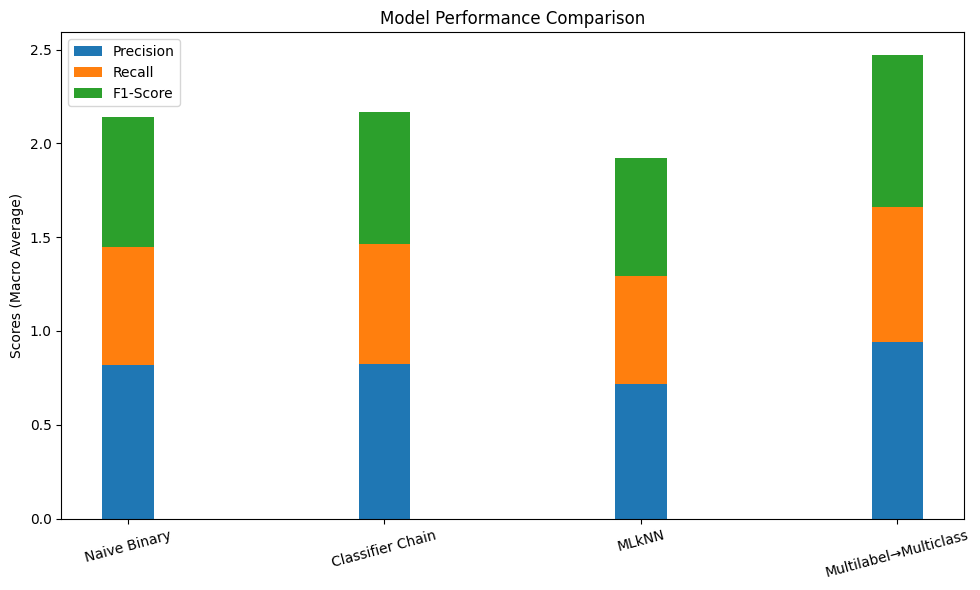

In [24]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Bar chart
x = metrics_df['Model']
width = 0.2

plt.bar(x, metrics_df['Precision'], width=width, label='Precision')
plt.bar(x, metrics_df['Recall'], width=width, label='Recall', bottom=metrics_df['Precision'])
plt.bar(x, metrics_df['F1-Score'], width=width, label='F1-Score', bottom=metrics_df['Precision'] + metrics_df['Recall'])

plt.title("Model Performance Comparison")
plt.ylabel("Scores (Macro Average)")
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [25]:
print(metrics_df)


                   Model  Precision    Recall  F1-Score
0           Naive Binary   0.820217  0.624759  0.694825
1       Classifier Chain   0.821161  0.640018  0.706115
2                  MLkNN   0.716608  0.577932  0.625919
3  Multilabel→Multiclass   0.938972  0.722389  0.807050


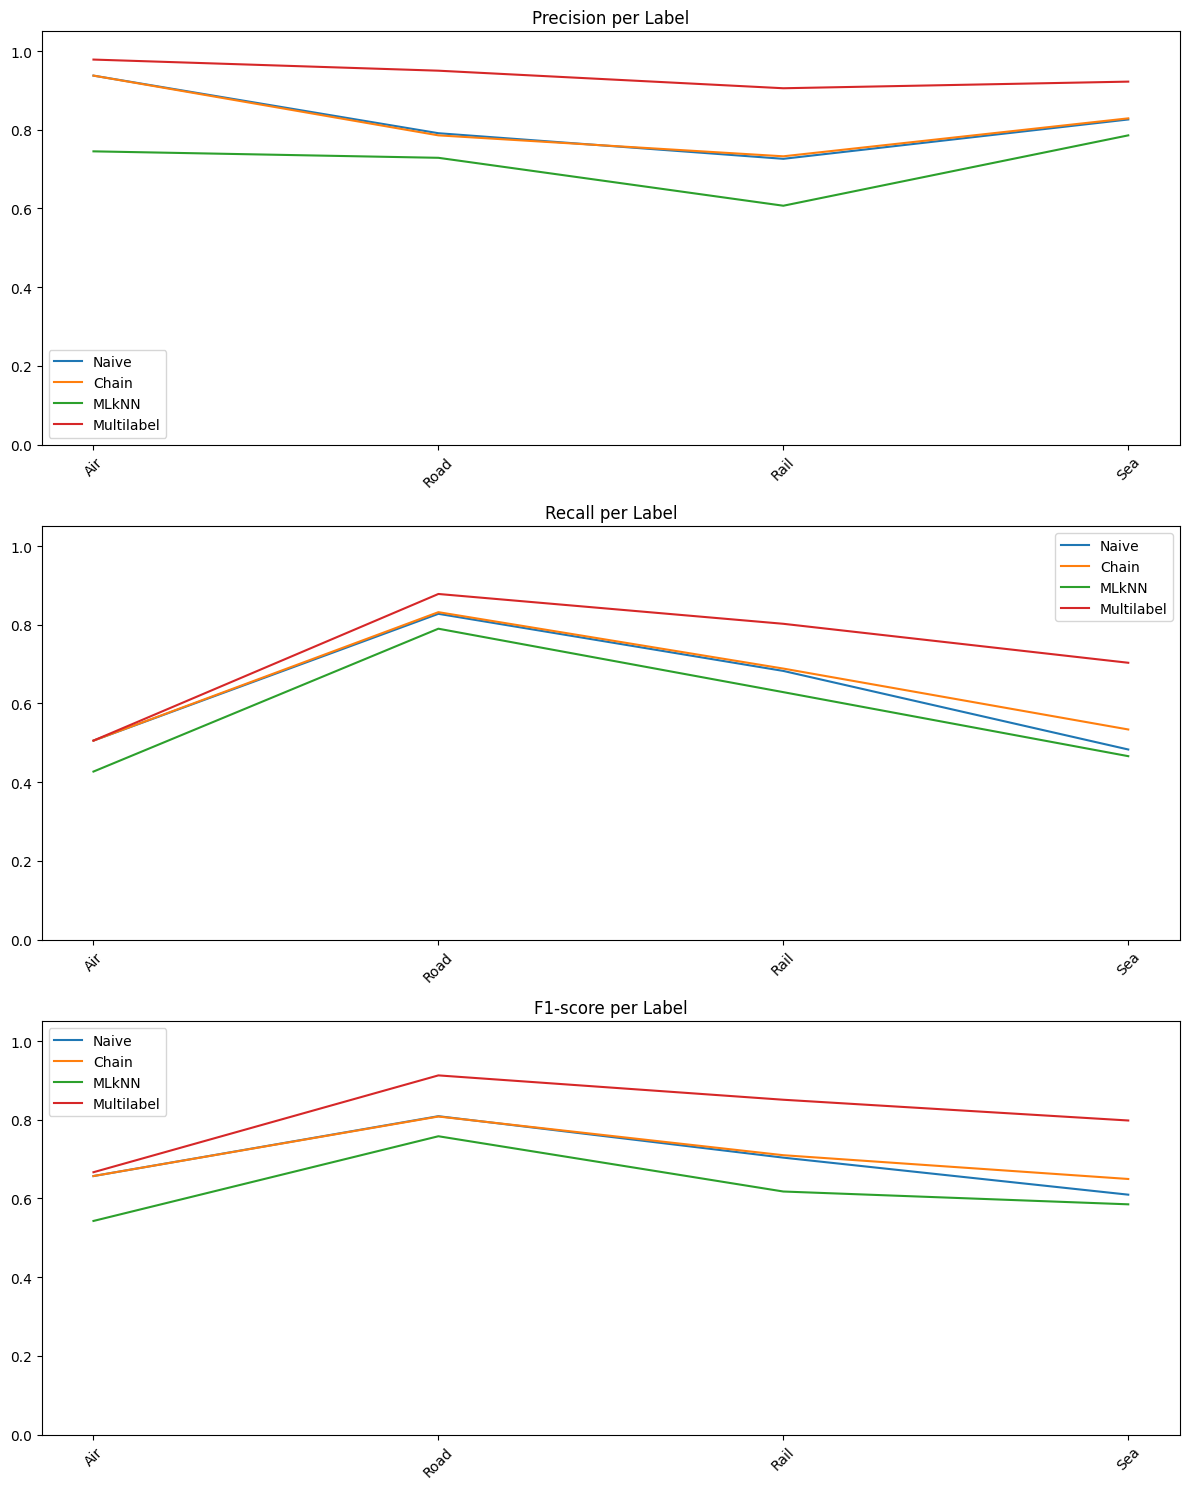

In [26]:
#plot per label
def plot_per_label_scores(y_test, y_preds, model_names):
    label_names = y_test.columns
    fig, axes = plt.subplots(nrows=3, figsize=(12, 15))

    for idx, metric in enumerate(['precision', 'recall', 'f1-score']):
        for y_pred, name in zip(y_preds, model_names):
            scores = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)[idx]
            axes[idx].plot(label_names, scores, label=name)
        axes[idx].set_title(f"{metric.capitalize()} per Label")
        axes[idx].set_ylim(0, 1.05)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

# Call with all models
plot_per_label_scores(
    y_test,
    [y_pred_naive, y_pred_chain, y_pred_mlk, y_pred_multilabel],
    ["Naive", "Chain", "MLkNN", "Multilabel"]
)

In [27]:
best_model = metrics_df.sort_values(by='F1-Score', ascending=False).iloc[0]
print(f"Best Performing Model: {best_model['Model']}")
print(f"Precision: {best_model['Precision']:.2f}")
print(f"Recall: {best_model['Recall']:.2f}")
print(f"F1-Score: {best_model['F1-Score']:.2f}")

Best Performing Model: Multilabel→Multiclass
Precision: 0.94
Recall: 0.72
F1-Score: 0.81


In [28]:
metrics_df.to_csv("model_comparison_metrics.csv", index=False)
print("Metrics saved as model_comparison_metrics.csv")

Metrics saved as model_comparison_metrics.csv


In [29]:
#Encode multilabels to single multiclass label
le = LabelEncoder()
y_train_mc = le.fit_transform(y_train.apply(lambda x: ','.join(map(str, x)), axis=1))
y_test_mc = le.transform(y_test.apply(lambda x: ','.join(map(str, x)), axis=1))

# Train a multiclass model
final_model = LogisticRegression(max_iter=2000, solver='lbfgs')
final_model.fit(X_train, y_train_mc)

# You can use these to predict later
# y_pred_mc = final_model.predict(X_test)
# decoded_preds = le.inverse_transform(y_pred_mc)


LogisticRegression(max_iter=2000)

In [30]:
import joblib
best_model_name = metrics_df.sort_values(by='F1-Score', ascending=False).iloc[0]['Model']
print("Best model:", best_model_name)
model_dict = {
    "Naive Binary": model_naive,
    "Classifier Chain": model_chain,
    "MLkNN": model_mlk,
    "Multilabel→Multiclass": final_model 
}
joblib.dump(model_dict[best_model_name], "best_model.pkl")
print(f"{best_model_name} saved as best_model.pkl")

Best model: Multilabel→Multiclass
Multilabel→Multiclass saved as best_model.pkl


### Testing saved model

In [31]:
# Load the saved model
model = joblib.load("best_model.pkl")

# Example prediction
def predict_shipment_mode(sample_features):
    if isinstance(sample_features, pd.Series):
        sample_df = sample_features.to_frame().T
    elif isinstance(sample_features, np.ndarray):
        sample_df = pd.DataFrame([sample_features], columns=X_test.columns)
    else:
        sample_df = sample_features  # assuming it's already a DataFrame

    prediction = model.predict(sample_df)
    print("Predicted Class Label (Multiclass):", prediction[0])
    return prediction[0]
predict_shipment_mode(X_test.iloc[0].values)

Predicted Class Label (Multiclass): 6


np.int64(6)

In [32]:
def decode_multiclass_label(label_int, num_labels=3):
    return [int(bit) for bit in format(label_int, f'0{num_labels}b')]
label_int = predict_shipment_mode(X_test.iloc[0])
multilabel = decode_multiclass_label(label_int)
print("Decoded Multilabel:", multilabel)

Predicted Class Label (Multiclass): 6
Decoded Multilabel: [1, 1, 0]


In [33]:
# Save feature list
feature_list = X_train.columns.tolist()
joblib.dump(feature_list, "feature_list.pkl")
print("Feature list saved.")

Feature list saved.


In [34]:
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved.")

Scaler saved.
